In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use("Agg")
from Utils import *
from Robot import Robot
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import random
from random import gauss,uniform
from random import seed
from Networks import Actor, Critic

In [2]:
seed(1821)

DH_params=np.array([[np.pi/2.0,0.0,0.4],
                    [0.0,0.4,0.0],
                    [0.0,0.4,0.0],
                   ])
q0=np.zeros(DH_params.shape[0])
robot=Robot(DH_params,q0)
robot.kinematics()
#robot.x0=[0,0,0,0,0,0,0,0,0]
robot.goal=np.array([0.0,-0.8,0.4])

In [3]:
P_net = Actor().cuda()
Pt_net= Actor().cuda()
Q_net = Critic().cuda()
Qt_net= Critic().cuda()

for Qt_param, Q_param in zip(Qt_net.parameters(), Q_net.parameters()):
    Qt_param.data.copy_(Q_param.data)
for Pt_param, P_param in zip(Pt_net.parameters(), P_net.parameters()):
    Pt_param.data.copy_(P_param.data)

Q_loss = torch.nn.MSELoss(reduction='mean').cuda()
Q_optimizer = torch.optim.Adam(Q_net.parameters(), lr=1e-3, weight_decay=1e-2)
P_optimizer = torch.optim.Adam(P_net.parameters(), lr=1e-4)

Q_Scheduler = torch.optim.lr_scheduler.StepLR(Q_optimizer, step_size=5000, gamma=0.1,last_epoch=-1)
P_Scheduler = torch.optim.lr_scheduler.StepLR(P_optimizer, step_size=5000, gamma=0.1,last_epoch=-1)


batch_size=32
max_size=1000000
D=Replay_Buffer(batch_size,max_size)
tau=0.01
gamma=torch.FloatTensor([0.99]).cuda()
Episodes=50000
Warm_Up=5000
T=750
robot.step_size=0.01
eps = np.finfo(float).eps
best_score=-float('Inf')
episode=0
noise_std=5.0
Success_Rate=[]

In [4]:
filename="BackUp_States/State_19999.pth"
checkpoint = torch.load(filename)
P_net.load_state_dict(checkpoint['P_state_dict'])
Pt_net.load_state_dict(checkpoint['Pt_state_dict'])
Q_net.load_state_dict(checkpoint['Q_state_dict'])
Qt_net.load_state_dict(checkpoint['Qt_state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Test for episode = 4999
Episode = 4999 , Success_Rate = 35.0 


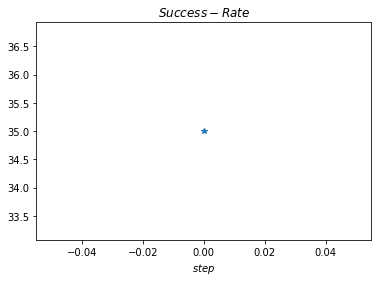

Test for episode = 7499
Episode = 7499 , Success_Rate = 62.0 


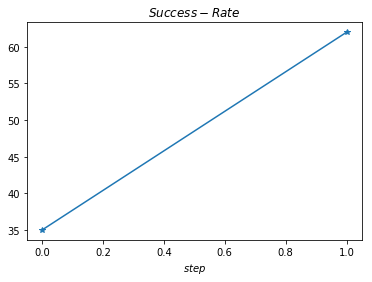

Test for episode = 9999
Episode = 9999 , Success_Rate = 55.00000000000001 


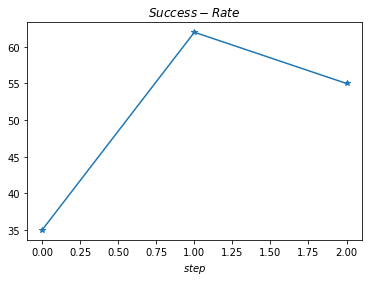

Test for episode = 12499
Episode = 12499 , Success_Rate = 67.0 


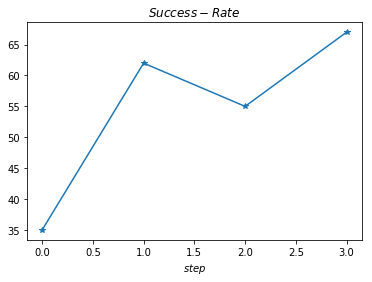

Test for episode = 14999
Episode = 14999 , Success_Rate = 86.0 


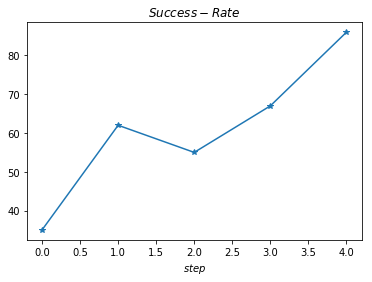

Test for episode = 17499
Episode = 17499 , Success_Rate = 82.0 


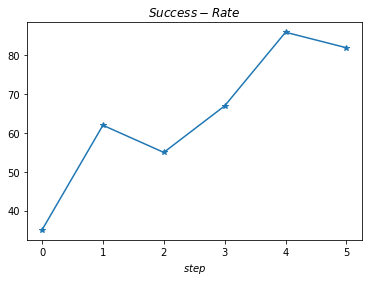

Test for episode = 19999
Episode = 19999 , Success_Rate = 79.0 


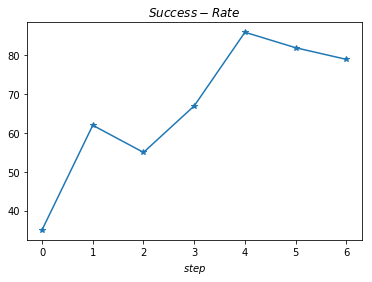

Test for episode = 22499
Episode = 22499 , Success_Rate = 78.0 


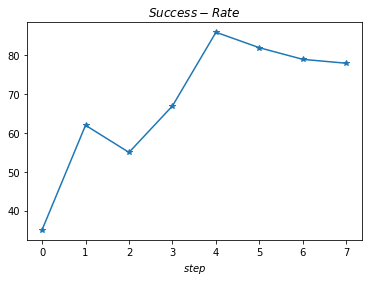

Test for episode = 24999
Episode = 24999 , Success_Rate = 92.0 


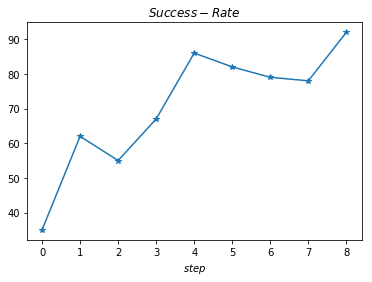

Test for episode = 27499
Episode = 27499 , Success_Rate = 93.0 


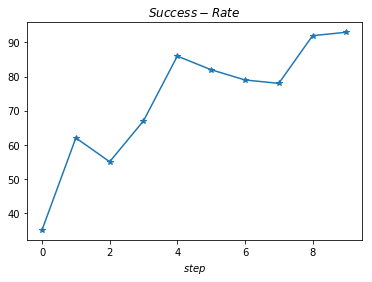

Test for episode = 29999
Episode = 29999 , Success_Rate = 88.0 


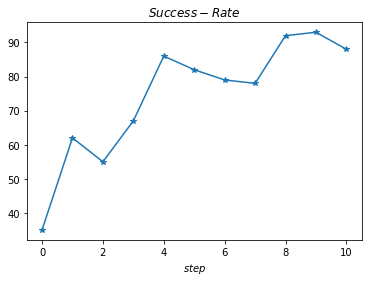

Test for episode = 32499
Episode = 32499 , Success_Rate = 87.0 


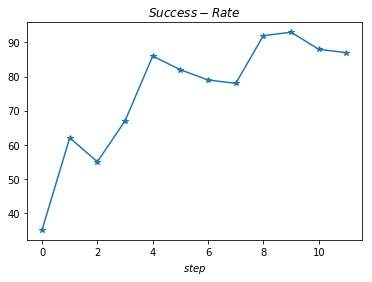

Test for episode = 34999
Episode = 34999 , Success_Rate = 94.0 


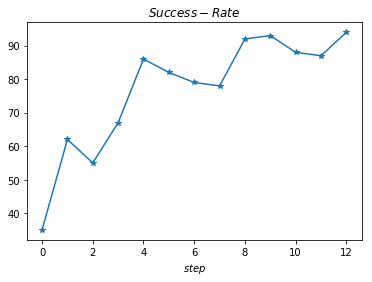

Test for episode = 37499
Episode = 37499 , Success_Rate = 90.0 


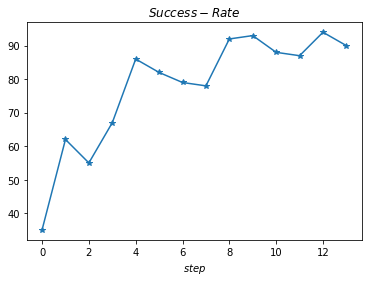

Test for episode = 39999
Episode = 39999 , Success_Rate = 88.0 


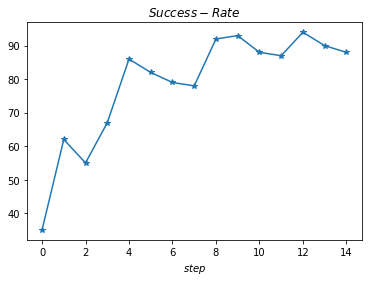

Test for episode = 42499
Episode = 42499 , Success_Rate = 87.0 


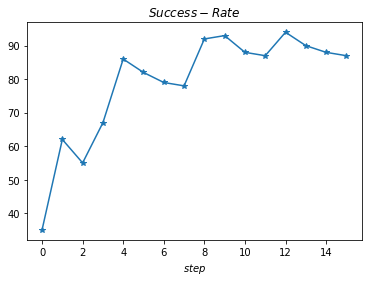

Test for episode = 44999
Episode = 44999 , Success_Rate = 93.0 


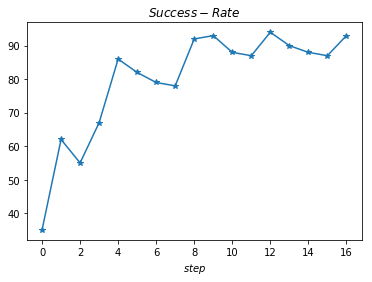

Test for episode = 47499
Episode = 47499 , Success_Rate = 94.0 


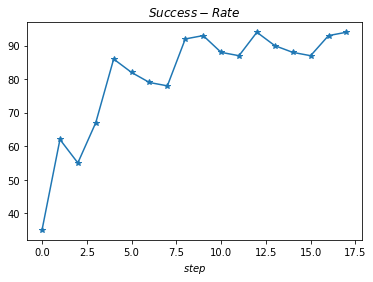

Test for episode = 49999
Episode = 49999 , Success_Rate = 96.0 


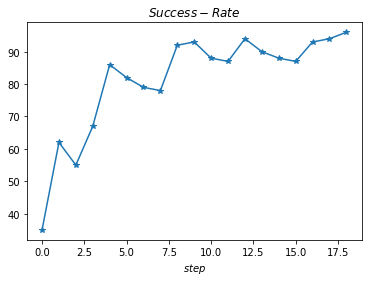

In [6]:
for episode in range(episode,Episodes):
   # print(episode)
   
    buff=buffer()
    
    robot.goal=np.array([uniform(-0.1,0.1),uniform(-0.5,-0.7),uniform(0.1,0.3)])
    robot.x0=np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.])
    robot.q=robot.x0[3:6]
    robot.kinematics()
    s1 = [gauss(0.0, noise_std) for i in range(T)]
    s2 = [gauss(0.0, noise_std) for i in range(T)]
    s3 = [gauss(0.0, noise_std) for i in range(T)]
    for t in range(T):
        P_net.eval()
        state=torch.FloatTensor(np.append(np.append(np.append(robot.x0[0:6],robot.acc),robot.goal),robot.end_effector()))
        u=P_net(state.unsqueeze_(0).cuda())
        u=torch.clamp(u+torch.FloatTensor([s1[t],s2[t],s3[t]]).cuda(),min=-1.0, max=1.0)
        robot.get_input(u.cpu().data[0].numpy())
        sol,r,d=robot.step()
        buff.update(sol,r)
        next_state=torch.FloatTensor(np.append(np.append(np.append(robot.x0[0:6],robot.acc),robot.goal),robot.end_effector()))
        D.store((state.cpu().data[0].numpy(),u.cpu().data[0].numpy(),r,d,next_state.cpu().data.numpy()))
        if (d==1):
            break
        if (D.size>Warm_Up):
            P_net.train()
            state,a,r,d,next_state=D.get_batch()
            state=state.cuda()
            next_state=next_state.cuda()
            a=a.cuda()
            r=r.cuda()
            d=d.cuda()
            y_t=r+gamma*(1.0-d)*Qt_net((next_state,Pt_net(next_state)))
            y_t=y_t.detach()
            #Qloss
            Q_loss(y_t,Q_net((state,a))).backward(retain_graph=True)
            #Ploss
            U=P_net(state)
            (-Q_net((state,U ))).mean().backward(retain_graph=True)
            P_optimizer.step()
            P_optimizer.zero_grad()
            Q_optimizer.step()
            Q_optimizer.zero_grad()
            for Qt_param, Q_param in zip(Qt_net.parameters(), Q_net.parameters()):
                Qt_param.data.copy_((1.0 - tau)*Qt_param.data + tau*Q_param.data)
            for Pt_param, P_param in zip(Pt_net.parameters(), P_net.parameters()):
                Pt_param.data.copy_((1.0 - tau) * Pt_param.data + tau*P_param.data)
    #if ((episode)%100==0 and D.size>Warm_Up):
    #    print(episode)
    #    robot.show(buff)
    #    robot.plot_sol(buff)
    if (((episode+1)%2500)==0 and D.size>Warm_Up):
        print("Test for episode =",episode)
        tests_no=100
        success_rate=0.0
        for i in range(tests_no):
            robot.goal=np.array([uniform(-0.1,0.1),uniform(-0.5,-0.7),uniform(0.1,0.3)])            
            buff=buffer()
            robot.x0=np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.])
            robot.q=robot.x0[3:6]
            robot.kinematics()
            P_net.eval()
            for t in range(T):
                state=torch.FloatTensor(np.append(np.append(np.append(robot.x0[0:6],robot.acc),robot.goal),robot.end_effector()))
                u=P_net(state.unsqueeze_(0).cuda())
                robot.get_input(u.cpu().data[0].numpy())
                sol,r,d=robot.step()
                buff.update(sol,r)
                if (robot.Distance()<0.05):
                    success_rate=success_rate+1.0    
                    break
            #robot.show(buff)
            #robot.plot_sol(buff)   
            #filename="Animations/Animation_Episode_"+str(episode)+"test_"+str(i)+".mp4"
            #robot.animate(buff,filename)
            #print("Animation saved for episode = ",episode) 
        success_rate=100.0*(success_rate/tests_no)   
        Success_Rate.append(success_rate)
        filename="Fine_Tuned_States/State_"+str(episode)+".pth"
        Save_States(P_net,Pt_net,Q_net,Qt_net,P_optimizer,Q_optimizer,episode,batch_size,buff.r,filename)
        print("Episode = {} , Success_Rate = {} ".format(episode,success_rate))        
        plt.figure()
        plt.title(r"$Success-Rate$")
        plt.plot(Success_Rate,"-*")
        plt.xlabel(r"$step$")
        plt.show()
    if ((episode%10000)==0 and D.size>Warm_Up):            
        Q_Scheduler.step()
        P_Scheduler.step()
        noise_std=0.5*noise_std

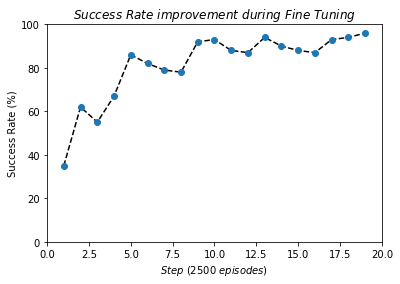

In [40]:
plt.figure()
plt.title(r"$ Success \ Rate \ improvement \ during  \ Fine \ Tuning $")
plt.plot(range(1,len(Success_Rate)+1),Success_Rate,"--k",range(1,len(Success_Rate)+1),Success_Rate,"o")
plt.xlabel(r"$Step \ (2500 \ episodes) $")
plt.ylabel("Success Rate (%)")
plt.axis(xmin=-0, xmax=20, ymin=0, ymax=100)
plt.show()
